This [Colab](https://research.google.com/colaboratory/faq.html) notebook is meant to be used as a quick demonstration of DeLTA's 
capabilities. Use of Google Colab is free, but Google might kill your process if
you use too many resources. We offer 3 approaches to run evaluations for movies 
that we have made available with our software, but you can copy and modify this 
notebook to run on your own data. If you would like to know more check out our
Gitlab repository:

https://gitlab.com/dunloplab/delta

⚠ Important ⚠

Before you get started, make sure you run this notebook with a GPU:
```
Menu > Runtime > Change runtime type
```

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun 12 08:31:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installation and setup

> *For each code cell below, you will need to run it by clicking the play button (you also can collapse this whole installation section with the down arrow on the left and run it all as one big cell)*


First, download the code and install the environment. Here we are going to do it through pip and use the sources from gitlab because conda takes a very long time to resolve the environment in Colab for some reason:

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://gitlab.com/dunloplab/delta.git '/content/drive/MyDrive/delta/'

fatal: destination path '/content/drive/MyDrive/delta' already exists and is not an empty directory.


Install the required libraries with pip (+python-bioformats to read nd2s etc):
> *(if the following cell produces an error message about folium and imgaug it can be safely ignored)*

In [3]:
!pip install folium==0.2.1
!pip install urllib3==1.25.4
!pip install -r /content/drive/MyDrive/delta/requirements.txt
!pip install python-bioformats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.4 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=2a5e91bd5d1d5dd1bc087a5dcc0f8fa7b9c64810b5ba3cdc950de382a8a87b63
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 7.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simp

Add the delta folder to the python path:

In [4]:
import sys
import os
print(os.path.exists('/content/drive/MyDrive/delta'))
sys.path.append('/content/drive/MyDrive/delta')

True


Import DeLTA:

In [5]:
import delta

/content/drive/MyDrive/delta/delta/data.py:28: UserWarning: Could not load elastic deformations module.
  warnings.warn("Could not load elastic deformations module.")


Download latest models:

In [ ]:
delta.assets.download_assets(
    load_models=False, # load_models=False if using the trained model
    load_sets=False,
    load_evals=False,
    config_level='global'
)

Config files written to /content/drive/MyDrive/delta/delta/assets/config


Extra imports and misc function definitions:

In [6]:
# To download files to your local drive:
from google.colab.files import download as colab_download
from google.colab.files import upload as colab_upload

# To display resuults movies:
from IPython.display import HTML
from base64 import b64encode

def display_movie(filename):
  mp4 = open(filename,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=600 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url
  )

In [7]:
!pip install -U kora
from kora.drive import upload_public

def show_movie(filename):
  url = upload_public(filename)
  # then display it
  from IPython.display import HTML
  return HTML(f"""<video src={url} width=500 controls/>""")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 3.7 MB/s 
     |████████████████████████████████| 60 kB 8.2 MB/s 


# Process sequence folder:

Here we will use the private function _download_and_unzip() to retrieve a zipped
image sequence folder, read it with an xpreader object, and process it with the main DeLTA Pipeline:

> *The following example will take about 20 minutes to run. For a shorter demonstration comment ppln.process() and uncomment the last line*

In [ ]:
def rename_file(folder_name):
  # rename the file in extract_folder
  time_len = 6
  prefix = 'pos1cha1fra'
  file_path = '/content/drive/MyDrive/delta/n_eval_movie_folder/'+folder_name+'/'+folder_name+'/'
  file_list=os.listdir(file_path)
  for item in file_list:
    old_name = '/content/drive/MyDrive/delta/n_eval_movie_folder/'+folder_name+'/'+folder_name+'/'+item
    prefix_1 = '0' * int(time_len - (len(item.split('_')[4].replace('t','')) - 4))
    new_name = '/content/drive/MyDrive/delta/n_eval_movie_folder/' + folder_name + '/' +folder_name + '/' + prefix + prefix_1 + item.split('_')[4].replace('t','').replace('TIF','tif')
    os.rename(old_name, new_name)

In [ ]:
# try the s11 folder
rename_file('s11')

In [ ]:
# Don't forget to modify the config/config_2D.json before runing the code
# Use the new model for segmentation and tracking

# First load 2D config:
delta.config.load_config(presets='2D')

# Download movie sequence (you can replace this with your own zip's ID)
# Download the zip file from google_drive_ID and load it temporary_zip, and finally extract it to extract_folder

google_drive_ID = '1kbRdKStjVSyjx96ulCj2zp3A1a6iZgnP' # This can be extracted from the URL of any publically available gdrive file

temporary_zip = '/content/drive/MyDrive/delta/data/tmp.zip'

extract_folder = '/content/drive/MyDrive/delta/n_eval_movie_folder/s10/' # avoid results overlap

delta.assets._download_and_unzip(
    google_drive_ID,
    temporary_zip,
    extract_folder
)

# rename the movie sequence
try:
  rename_file('s10')
  print("Renamed!")
except:
  print("Already Renamed!")

# Init xpreader:
# (make sure you update prototype parameters if you use your own movie)
reader = delta.utilities.xpreader(
    extract_folder,
    prototype='s10/pos%01dcha%01dfra%06d.tif',
    fileorder='pct',
    filenamesindexing=1
)

# Print experiment parameters to make sure it initialized properly:
print("""Initialized experiment reader:
    - %d positions
    - %d imaging channels
    - %d timepoints"""%(reader.positions, reader.channels, reader.timepoints)
)

print(reader.timepoints)

# Init Pipeline:
ppln = delta.pipeline.Pipeline(reader)

# Run it (~20 min):
# ppln.process()

# Or you can run a subset of frames (5min):
ppln.process(frames=list(range(10)))

Loading configuration from: /content/drive/MyDrive/delta/delta/assets/config/config_2D.json
Extracting to /content/drive/MyDrive/delta/n_eval_movie_folder/s10/... Done
Deleting archive... Done
Already Renamed!
Initialized experiment reader:
    - 1 positions
    - 1 imaging channels
    - 151 timepoints
151
Fri Jun 10 13:51:10 2022, Position 0 - Starting pre-processing
Fri Jun 10 13:51:10 2022, Position 0 - Starting segmentation (10 frames)
Fri Jun 10 13:51:25 2022, Position 0 - Starting tracking (10 frames)
Fri Jun 10 13:51:25 2022, Position 0 - Tracking - frame 0/10 
Fri Jun 10 13:51:26 2022, Position 0 - Tracking - frame 1/10 
Fri Jun 10 13:51:27 2022, Position 0 - Tracking - frame 2/10 
Fri Jun 10 13:51:28 2022, Position 0 - Tracking - frame 3/10 
Fri Jun 10 13:51:30 2022, Position 0 - Tracking - frame 4/10 
Fri Jun 10 13:51:31 2022, Position 0 - Tracking - frame 5/10 
Fri Jun 10 13:51:33 2022, Position 0 - Tracking - frame 6/10 
Fri Jun 10 13:51:34 2022, Position 0 - Tracking - fr

In [ ]:
# Display output movie:
# display_movie(ppln.resfolder/"Position000000.mp4")
# absolute path
import os
# print(os.path.exists('/content/drive/MyDrive/delta/n_eval_movie_folder/delta_results/Position000000.mp4'))
# display_movie("/content/drive/MyDrive/delta/n_eval_movie_folder/delta_results/Position000000.mp4")
show_movie('/content/drive/MyDrive/delta/n_eval_movie_folder/s10/delta_results/Position000000.mp4')

In [ ]:
# Download result files to your own computer:
# colab_download(ppln.resfolder /"Position000000.mat")
colab_download('/content/drive/MyDrive/delta/n_eval_movie_folder/s10/delta_results/Position000000.mat')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Process Bio-Formats file:

Here we will process a subset of positions on an nd2 file of a mother machine movie.

In [ ]:
# First load mothermachine config:
delta.config.load_config(presets='mothermachine')

# Download movie sequence (you can replace this with your own file's ID)
google_drive_ID = '1YEvhkNB2lWOGFAuG1bmV7ZcwFE1FiDaR' # This can be extracted from the URL of any publically available gdrive file
filename = '/content/eval_movie_moma.nd2'
delta.assets._download_file_from_google_drive(
    google_drive_ID,
    filename
)

# Init xpreader:
reader = delta.utilities.xpreader(
    filename,
    use_bioformats=True
)

# Print experiment parameters to make sure it initialized properly:
print("""Initialized experiment reader:
    - %d positions
    - %d imaging channels
    - %d timepoints"""%(reader.positions, reader.channels, reader.timepoints)
)

# Init Pipeline:
ppln = delta.pipeline.Pipeline(reader)

# Run it (~20 min):
ppln.process(positions=[2,3,5])

Loading configuration from: /content/delta/delta/assets/config/config_mothermachine.json
Initialized experiment reader:
    - 15 positions
    - 2 imaging channels
    - 193 timepoints
Thu Jan 13 15:57:46 2022, Position 2 - Starting pre-processing
Thu Jan 13 15:58:11 2022, Position 2 - Starting segmentation (193 frames)
Thu Jan 13 16:00:36 2022, Position 2 - Starting tracking (193 frames)
Thu Jan 13 16:00:36 2022, Position 2 - Tracking - frame 0/193 
Thu Jan 13 16:00:36 2022, Position 2 - Tracking - frame 1/193 
Thu Jan 13 16:00:47 2022, Position 2 - Tracking - frame 2/193 
Thu Jan 13 16:00:51 2022, Position 2 - Tracking - frame 3/193 
Thu Jan 13 16:00:54 2022, Position 2 - Tracking - frame 4/193 
Thu Jan 13 16:00:57 2022, Position 2 - Tracking - frame 5/193 
Thu Jan 13 16:00:59 2022, Position 2 - Tracking - frame 6/193 
Thu Jan 13 16:01:00 2022, Position 2 - Tracking - frame 7/193 
Thu Jan 13 16:01:03 2022, Position 2 - Tracking - frame 8/193 
Thu Jan 13 16:01:08 2022, Position 2 - Tr

In [ ]:
# Display output movie:
display_movie(ppln.resfolder / 'Position000003.mp4')

In [ ]:
# Zip all results and download:
from zipfile import ZipFile
import glob

with ZipFile('results_files.zip', 'w') as myzip:
    for res_file in glob.glob(str(ppln.resfolder) + '/*'):
        print('zipping %s'%res_file)
        myzip.write(res_file)

colab_download('results_files.zip')

zipping /content/eval_movie_moma_delta_results/Position000003.mp4
zipping /content/eval_movie_moma_delta_results/Position000005.pkl
zipping /content/eval_movie_moma_delta_results/Position000002.mat
zipping /content/eval_movie_moma_delta_results/Position000005.mat
zipping /content/eval_movie_moma_delta_results/Position000005.mp4
zipping /content/eval_movie_moma_delta_results/Position000002.mp4
zipping /content/eval_movie_moma_delta_results/Position000002.pkl
zipping /content/eval_movie_moma_delta_results/Position000003.pkl
zipping /content/eval_movie_moma_delta_results/Position000003.mat


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Process file from your google drive directly

Here is an example of how you can mount your own google drive, process a file in there (or potentially several), and directly get your results back in your google drive when they are ready. Before executing 
this cell, please mount your google drive through the files tab on the left

In [ ]:
import shutil
import glob

# Load the appropriate config:
delta.config.load_config(presets='2D')

# Mount path:
drive_path = '/content/drive/MyDrive'

# Path to your file and results folder in your google drive:
filename = '/path/to/file/in/my/drive.nd2'
results_folder = '/path/to/results/folder/in/drive/' # This folder must exist

# copy file to local disk to avoid i/o problems:
local_file = "/content/local_file_copy.nd2"
shutil.copy(drive_path+filename, local_file)

# Init:
reader = delta.utilities.xpreader(local_file, use_bioformats=True)
sequence_ppln = delta.pipeline.Pipeline(reader, resfolder='./local_results/')

# Run:
sequence_ppln.process(positions=[0,1], frames=list(range(30)))

# copy output files to drive:
for res_file in glob.glob(str(sequence_ppln.resfolder) + '/*'):
    shutil.copy(res_file, drive_path+results_folder)

# Generate Weight Map

In [ ]:
!pip install libtiff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 35.0 MB/s 
  Created wheel for libtiff: filename=libtiff-0.4.2-cp37-cp37m-linux_x86_64.whl size=285114 sha256=02a7490f1a80ec2bd2b98b3c8d4bc15b59eac0f0f5dde3751dee26ad80bda507
  Stored in directory: /root/.cache/pip/wheels/ea/3d/1d/9ad926b88ecfd8719065c57ad36808810a77123c4647e8d341
Successfully built libtiff


In [ ]:
import numpy as np
from libtiff import TIFF
import matplotlib.pyplot as plt
from tifffile import imsave
import openpyxl
from openpyxl import Workbook

In [ ]:
def save_to_excel(image, image_name):
  wb = openpyxl.Workbook()
  ws = wb.active

  ws.title = "prediction_image"
  for x in image:
    ws.append(x.tolist())
  wb.save(filename='/content/drive/MyDrive/delta/trainging_set/training/segmentation_set/wei/'+image_name+'.xlsx')

In [ ]:
# Load all the images from folder
folder_path = os.walk('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s11/seg/')
image_list = []
for path, dir, filelist in folder_path:
  for filename in filelist:
    image_list.append(filename)
print(image_list)

['sample (1).tif', 'sample (2).tif', 'sample (3).tif', 'sample (4).tif', 'sample (5).tif', 'sample (6).tif', 'sample (7).tif', 'sample (8).tif', 'sample (9).tif', 'sample (11).tif', 'sample (10).tif']


In [ ]:
# Don't forget to run the code in the previous block
print(image_list)

for image_name in image_list:

  print(os.path.exists('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s11/seg/' + image_name))

  # tif = TIFF.open('/content/drive/MyDrive/delta/trainging_set/training/segmentation_set/seg/Sample000307.png',mode='r') # example for test

  tif = TIFF.open('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s11/seg/' + image_name ,mode='r')
  mask_image = tif.read_image()

  # weight = delta.data.seg_weights(mask = mask_image, classweights = (1,1), w0 = 12, sigma = 2)
  weight = delta.data.seg_weights_2D(mask = mask_image, classweights = (1,1))

  # plt.imshow(weight)
  imsave('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s11/wei/' + image_name, (weight*255).astype(np.uint8))

['sample (1).tif', 'sample (2).tif', 'sample (3).tif', 'sample (4).tif', 'sample (5).tif', 'sample (6).tif', 'sample (7).tif', 'sample (8).tif', 'sample (9).tif', 'sample (11).tif', 'sample (10).tif']
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
'''
import imageio
I = imageio.imread('/content/drive/MyDrive/delta/trainging_set/training/segmentation_set/wei/Sample000307_test.png')
I
'''

"\nimport imageio\nI = imageio.imread('/content/drive/MyDrive/delta/trainging_set/training/segmentation_set/wei/Sample000307_test.png')\nI\n"

# Rename the images

In [ ]:
# folder_name: s1, s2, s3...
def rename_file(folder_name):
  file_path = '/content/drive/MyDrive/delta/trainging_set/training/seg_combination/' + folder_name
  img_path = os.path.join(file_path, "img/")
  seg_path = os.path.join(file_path, "seg/")
  wei_path = os.path.join(file_path, "wei/")
  # print(img_path, seg_path, wei_path)

  for path in [img_path, seg_path, wei_path]:
    file_list = os.listdir(path)
    for item in file_list:
      old_name = path + item
      new_name = path + folder_name + "_" + str(item).replace('(','').replace(')','').split(' ')[1]
      os.rename(old_name, new_name)

rename_file('s11')

# Combine all the images together



In [ ]:
# combine all the images from s1, s2, s3 to seg_combination/img, seg_combination/seg, seg_combination/wei

import glob
import shutil

folder_list = ['s1', 's2', 's3','s4','s5', 's6', 's7', 's8','s9', 's10', 's11']
file_path = '/content/drive/MyDrive/delta/trainging_set/training/seg_combination/'

for folder_type in ['img', 'seg', 'wei']:
  # combine all the images, segmentations and weights
  for folder_name in folder_list:
    # print(os.path.join(file_path, folder_type))
    original_filepath = os.path.join(file_path, folder_name + '/' + folder_type)
    new_filepath = os.path.join(file_path, folder_type)
    # print(original_filepath, new_filepath)
    filename = os.listdir(original_filepath)
    for item in filename:
      shutil.copy(original_filepath+'/'+item, new_filepath+'/'+item)
    print(original_filepath, " completed!, the num of image is: ", len(os.listdir(original_filepath)))

/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s1/img  completed!, the num of image is:  11
/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s2/img  completed!, the num of image is:  9
/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s3/img  completed!, the num of image is:  10
/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s4/img  completed!, the num of image is:  12
/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s5/img  completed!, the num of image is:  9
/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s6/img  completed!, the num of image is:  10
/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s7/img  completed!, the num of image is:  10
/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s8/img  completed!, the num of image is:  10
/content/drive/MyDrive/delta/trainging_set/training/seg_combination/s9/img  completed!, the num of

In [ ]:
# judge if the len(img) == len(seg) == len(wei) 
import os
file_img = os.listdir('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/img')
file_seg = os.listdir('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg')
file_wei = os.listdir('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/wei')
print(len(file_img), len(file_seg), len(file_wei))

113 113 113


# Convert png to img (not necessary)

In [ ]:
# convert tif image into png
import cv2

file_path = '/content/drive/MyDrive/delta/trainging_set/training/seg_combination/'
for folder_name in ['img', 'seg', 'wei']:
  for image_name in os.listdir(os.path.join(file_path, folder_name)):
    tif = TIFF.open(os.path.join(file_path, folder_name + '/' + image_name), mode = 'r')
    img = tif.read_image()
    cv2.imwrite(os.path.join(file_path + 'seg_training_set/' + folder_name + '/' + str(image_name).replace('TIF', 'png').replace('tif', 'png')), img)


In [9]:
import os
file_img = os.listdir('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_training_set/img')
file_seg = os.listdir('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_training_set/seg')
file_wei = os.listdir('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_training_set/wei')
print(len(file_img), len(file_seg), len(file_wei))

113 113 113


# Pre-processing before training

In [ ]:
import cv2

In [ ]:
# img folder: 归一化(0, 255)
'''
# Delta2.0 samples
I = cv2.imread('/content/drive/MyDrive/delta/trainging_set/training/segmentation_set/img/Sample000307.png', cv2.IMREAD_ANYDEPTH)
print(I)
'''

for image_name in os.listdir('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/img/'):
  I = cv2.imread(os.path.join('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/img/', image_name), cv2.IMREAD_ANYDEPTH)
  # Rescale to 0-255:
  I = ((I.astype(np.float32)-np.min(I))/np.ptp(I))*255
  # print(os.path.join('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_training_set/img/', str(image_name).replace('TIF', 'png').replace('tif', 'png')))
  cv2.imwrite(os.path.join('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_training_set/img/', str(image_name).replace('TIF', 'png').replace('tif', 'png')), I.astype(np.uint8))

In [ ]:
# Invert the pixel to (0,1)
def img_invert(image):
  image_r = [[0 for i in range(image.shape[1])] for i in range(image.shape[0])]
  for i in range(0, image.shape[0]):
    for j in range(0, image.shape[1]):
      if image[i][j] == 255:
        image_r[i][j] = 0 # 255->0
      else:
        image_r[i][j] = 1 # 0->1
  # print(np.array(image_r))
  # BFS/DFS to find the adjacent pixels to 1,2,3...
  image_r = np.array(image_r)
  return image_r

In [ ]:
# seg folder: 调整为背景0， 细胞1
# Delta2.0 samples
for image_name in os.listdir('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg/'):
  I = cv2.imread('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg/' + image_name, cv2.IMREAD_ANYDEPTH)
  II = img_invert(I)
  cv2.imwrite(os.path.join('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_training_set/seg/', str(image_name).replace('TIF', 'png').replace('tif', 'png')), (II*255).astype(np.uint8))

In [ ]:
# wei: 由process之后的seg求wei
for image_name in os.listdir('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_training_set/seg/'):
  I = cv2.imread(os.path.join('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_training_set/seg/', image_name), cv2.IMREAD_ANYDEPTH)
  III = delta.data.seg_weights_2D(mask = I, classweights = (1,1))
  cv2.imwrite(os.path.join('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_training_set/wei/', image_name), (III*255).astype(np.uint8))

# Training new models

You can download training sets and run our modified training
scripts as well. However bear in mind that you might run into google Colab's resource limits

Here, we are going to show an example to retrain the segmentation model for the 2D case

First, download our segmentation training set (or your own training set if you made one):

In [ ]:
# Download movie sequence (you can replace this with your own zip's ID)
# Don't run these code using your own data(take a long time to download and extract)
google_drive_ID = '1sWWkIDjIf77KwddHZgX64f8_LxV7hQx_' # This can be extracted from the URL of any publically available gdrive file
temporary_zip = '/content/tmp.zip'
extract_folder = '/content/drive/MyDrive/delta/trainging_set/'
delta.assets._download_and_unzip(
    google_drive_ID,
    temporary_zip,
    extract_folder
)

We then copy the example segmentation training script from the
gitlab and simply change the training set path:

In [ ]:
import os

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from delta.utilities import cfg
from delta.model import unet_seg
from delta.data import trainGenerator_seg
from delta.data import predictGenerator_seg

# Load config:
cfg.load_config(presets='2D')

In [ ]:
# 构造validation dataset
# randomly choose 10% images from seg_training_set
# move the images from seg_training_set to seg_validation_set
# remove the chosen images from seg_training_set

import random
import shutil

def moveFile(trainDir, valDir):
    pathDir = os.listdir(os.path.join(trainDir, 'img'))
    filenumber = len(pathDir)
    rate = 0.1
    picknumber = int(filenumber*rate)
    sample = random.sample(os.listdir(os.path.join(trainDir, 'img')), picknumber)  # randomly choose samples
    print(sample)
    for image_name in sample:
      for folder_name in ['img', 'seg', 'wei']:
        shutil.move(os.path.join(trainDir, folder_name + '/' + image_name), os.path.join(valDir, folder_name + '/' + image_name)) # move img
      print(image_name, " moved!")

trainDir = '/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_training_set/'
valDir = '/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_validation_set/'
moveFile(trainDir, valDir)

In [ ]:
import os
train_img = os.listdir('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_training_set/img')
val_img = os.listdir('/content/drive/MyDrive/delta/trainging_set/training/seg_combination/seg_validation_set/img')
print(len(train_img), len(val_img))

In [ ]:
import tensorflow as tf
from keras.callbacks import TensorBoard
import datetime, os
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

# Files:
# Point to extracted folder:
extract_folder = '/content/drive/MyDrive/delta/trainging_set/'
# training_set = extract_folder+'/training/segmentation_set' # original dataset
training_set = extract_folder + '/training/seg_combination/seg_training_set' # new dataset
validation_set = extract_folder + '/training/seg_combination/seg_validation_set'

# Overwrite seg model:
# savefile = cfg.model_file_seg
savefile = '/content/drive/MyDrive/delta/delta/assets/models/unet_pads_seg.hdf5'

# Training parameters:
# Larger than 50 epochs is necessary
batch_size = 8
epochs = 50 # original: 600
steps_per_epoch = 30 # original: 300
validation_steps = 1
patience = 10

#Data generator parameters:
data_gen_args = dict(
    rotation = 2,
    rotations_90d = True,
    zoom=.15,
    horizontal_flip=True,
    vertical_flip=True,
    histogram_voodoo=True,
    illumination_voodoo=True,
    gaussian_noise = 0.03,
    gaussian_blur = 1
    )


# Generator init:
myGene = trainGenerator_seg(
    batch_size,
    os.path.join(training_set,'img'),
    os.path.join(training_set,'seg'),
    os.path.join(training_set,'wei'),
    augment_params = data_gen_args,
    target_size = cfg.target_size_seg,
    crop_windows = cfg.crop_windows
    )

# Validation generator
myvalGene = trainGenerator_seg(
    batch_size,
    os.path.join(validation_set,'img'),
    os.path.join(validation_set,'seg'),
    os.path.join(validation_set,'wei'),
    augment_params = data_gen_args,
    target_size = cfg.target_size_seg,
    crop_windows = cfg.crop_windows
    )

# Define model:
model = unet_seg(input_size = cfg.target_size_seg+(1,))
model.summary()
keras.utils.plot_model(model)

# Load the TensorBoard notebook extension

%load_ext tensorboard
logdir = os.path.join("/content/drive/MyDrive/delta/trainging_set/training/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


# Callbacks:
model_checkpoint = ModelCheckpoint(
    savefile, monitor='loss', verbose=2, save_best_only=True
    )
early_stopping = EarlyStopping(
    monitor='loss', mode='min', verbose=2, patience=patience
    )

# Train:
# ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'generator'>]
history = model.fit(
    myGene,
    steps_per_epoch=steps_per_epoch,
    validation_data = myvalGene,
    validation_steps = 1,
    epochs=epochs,
    # callbacks=[model_checkpoint, early_stopping]
    callbacks=[model_checkpoint, early_stopping, tensorboard_callback],
    verbose = 1
    )

print("-----------------\n Model is saved in: ", savefile) # path of the new trained model

In [ ]:
%tensorboard --logdir "/content/drive/MyDrive/delta/trainging_set/training/logs/"

In [48]:
# Test Generator
import os
import glob

import numpy as np

from delta.data import saveResult_seg, predictGenerator_seg, postprocess, readreshape
from delta.model import unet_seg
import delta.utilities as utils
from delta.utilities import cfg

# Load config:
cfg.load_config(presets='2D')

# inputs: without groundtruth, inputs_1: with masks
# Input image sequence:
inputs_folder = "/content/drive/MyDrive/delta/testing_set/inputs1/"
# inputs_folder = os.path.join(cfg.eval_movie,'cropped_rois')

# Outputs folder:
outputs_folder = '/content/drive/MyDrive/delta/testing_set/outputs1/'
if not os.path.exists(outputs_folder):
  print("create new folders to put output images")
  os.makedirs(outputs_folder)

# List files in inputs folder:
# tif format or png format are both okay
unprocessed = sorted(
    glob.glob(inputs_folder + "/*.tif") + glob.glob(inputs_folder + "/*.png")
)

# Load up model:
model = unet_seg(input_size=cfg.target_size_seg + (1,))
model.load_weights(cfg.model_file_seg)

# Process
while unprocessed:
    # Pop out filenames
    ps = min(4096, len(unprocessed))  # 4096 at a time
    to_process = unprocessed[0:ps]
    del unprocessed[0:ps]

    # Input data generator:
    predGene = predictGenerator_seg(
        inputs_folder,
        files_list=to_process,
        target_size=cfg.target_size_seg,
        crop=cfg.crop_windows,
    )

    # mother machine: Don't crop images into windows
    if not cfg.crop_windows:
        # Predictions:
        results = model.predict(predGene, verbose=1)[:, :, :, 0]

    # 2D: Cut into overlapping windows
    else:
        img = readreshape(
            os.path.join(inputs_folder, to_process[0]),
            target_size=cfg.target_size_seg,
            crop=True,
        )
        # Create array to store predictions
        results = np.zeros((len(to_process), img.shape[0], img.shape[1], 1))
        # Crop, segment, stitch and store predictions in results
        for i in range(len(to_process)):
            # Crop each frame into overlapping windows:
            windows, loc_y, loc_x = utils.create_windows(
                next(predGene)[0, :, :], target_size=cfg.target_size_seg
            )
            # We have to play around with tensor dimensions to conform to
            # tensorflow's functions:
            windows = windows[:, :, :, np.newaxis]
            # Predictions:
            pred = model.predict(windows, verbose=1, steps=windows.shape[0])
            # Stich prediction frames back together:
            pred = utils.stitch_pic(pred[:, :, :, 0], loc_y, loc_x)
            pred = pred[np.newaxis, :, :, np.newaxis]  # Mess around with dims

            results[i] = pred

    # Post process results (binarize + light morphology-based cleaning):
    results = postprocess(results, crop=cfg.crop_windows)
    print(results.shape)

    # Save to disk:
    saveResult_seg(outputs_folder, results, files_list=to_process)

print(outputs_folder)

Loading configuration from: /content/drive/MyDrive/delta/delta/assets/config/config_2D.json
11/11 [==============================] - 1s 69ms/step
(11, 512, 512)
/content/drive/MyDrive/delta/testing_set/outputs1/


In [61]:
# print the acc of the test images in the testing_set folder
I = cv2.imread('/content/drive/MyDrive/delta/testing_set/outputs1/s2_3.png')
II = cv2.imread('/content/drive/MyDrive/delta/testing_set/segs1/s2_3.png')
accuracy = tf.keras.metrics.BinaryAccuracy()
accuracy_calc = accuracy(cv2.resize(I, (II.shape[0], II.shape[1])), II)
print(accuracy_calc, float(accuracy_calc))

tf.Tensor(0.96831024, shape=(), dtype=float32) 0.9683102369308472


You can now evaluate performance by using one of the methods described above, or run a simple segmentation prediction on our test data:


# Display the output images

In [ ]:
import openpyxl

In [ ]:
def save_to_excel(image, image_name):
  wb = openpyxl.Workbook()
  ws = wb.active
  ws.title = "prediction_image"
  for x in image:
    # ws.append(x.tolist())
    ws.append([float(str(i).replace('[','').replace(']','')) for i in x.tolist()])
  wb.save(filename='/content/drive/MyDrive/delta/tests/data/'+image_name+'.xlsx')

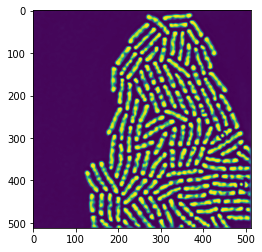

In [26]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython import display

files_folder = '/content/drive/MyDrive/delta/tests/data/movie_2D_tif/' # original test folder
images = glob.glob(files_folder+'/*.tif')
images.sort()

def fig_display(image):
  fig = plt.figure(figsize=(4,3))
  ax = fig.add_subplot(111)
  ax.imshow(image)

# re-define the model
model = unet_seg(input_size = cfg.target_size_seg+(1,))
# model.summary()

# Load weights from file:
# savefile = cfg.model_file_seg
# load the model from google drive
savefile = '/content/drive/MyDrive/delta/delta/assets/models/unet_pads_seg.hdf5'
model.load_weights(savefile)

for filename in images:
    
    # Read image:
    I = cv2.imread(filename, cv2.IMREAD_ANYDEPTH)

    # Rescale to 0-1:
    I = (I.astype(np.float32)-np.min(I))/np.ptp(I)

    # fig_display(I)

    # Run prediction:
    y = model.predict(I[np.newaxis,512:1024,512:1024,np.newaxis])
    # Display output:
    plt.imshow(y[0,:,:,0])
    display.display(plt.gcf())
    display.clear_output(wait=True)

# save the last prediction y for analysis
# save_to_excel(y[0,:,:,0], 'prediction_updated')

In [ ]:
import numpy
import openpyxl
# save the predicted results to excel

y_2d = y.reshape((512, 512)) 

wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Final_prediction"

for x in y_2d:
    ws.append(x.tolist())

wb.save(filename='/content/drive/MyDrive/delta/tests/data/test_result.xlsx')

# Extract information from .mat file

In [ ]:
! pip install scipy

In [ ]:
# # extract information from .mat file
! pip install scipy

import scipy.io as sio
mat_data = sio.loadmat('/content/drive/MyDrive/mat_and_vid_files/s10_21_05_2022/s10_21_05_2022.mat')

print(mat_data)
print(mat_data.keys)

流式输出内容被截断，只能显示最后 5000 行内容。
                                      dtype=float32), array([[13.      , 14.      , 16.736885, 18.842335, 20.506096, 24.956861,
                                        26.922148, 31.378834, 33.810364, 18.305107, 22.472073, 25.610949]],
                                      dtype=float32), array([[17., 17., 22., 18., 20., 24., 29., 31., 37., 23., 29., 25.]],
                                      dtype=float32), array([[980., 767.],
                                       [976., 771.],
                                       [973., 776.],
                                       [970., 778.],
                                       [966., 778.],
                                       [955., 784.],
                                       [952., 785.],
                                       [948., 787.],
                                       [945., 789.],
                                       [937., 792.],
                                       [932., 795.],
        